#  Vulnerability Testing  
This vulnerability testing aims to evaluate our final policies against each scenario within the PRIM box identified in the notebook "scenario_discovery_prim". The PRIM box contains 13,013 scenarios that fall within its limits.  

In this notebook, we will plot all scenarios for each policy against all outcomes. This visualization will help us identify whether different scenarios lead to varying outcomes for a given policy, thereby indicating potential vulnerabilities.  

We will also perform a PRIM analysis to identify concerning scenarios for our final policies. This will help us understand the conditions under which our policies are most likely to fail.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ema_workbench import (
    load_results,
    Policy,
    Scenario,
    MultiprocessingEvaluator
)

from ema_workbench.analysis import prim, parcoords
from ema_workbench.util import ema_logging, utilities

from custom_problem_formulation_no_RfR import get_model_for_problem_formulation

from sklearn.preprocessing import (MinMaxScaler)

In [19]:
# Get the 13013 scenarios from the other notebook
combined_df = pd.read_csv("results/PRIM_scenarios.csv", index_col=0)
print(combined_df.shape)
combined_df.head()

(13013, 54)


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
5666,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,...,0,0,0,0,0,0,5666,No Policy,dikesnet,3.851408
37006,112,45.942740,10.0,0.048710,140.411132,1.0,0.024664,82.938927,1.5,0.397429,...,0,0,0,0,0,0,37006,No Policy,dikesnet,3.842766
10872,124,40.037075,1.5,0.142803,341.756695,1.5,0.036182,77.097873,1.5,0.527626,...,0,0,0,0,0,0,10872,No Policy,dikesnet,3.806186
23514,8,71.302063,1.0,0.046825,345.456662,1.0,0.011393,30.957752,1.5,0.700170,...,0,0,0,0,0,0,23514,No Policy,dikesnet,3.743752
456,123,43.660903,10.0,0.199587,181.602356,1.0,0.058039,222.809776,1.5,0.212183,...,0,0,0,0,0,0,456,No Policy,dikesnet,3.716054


In [24]:
# Make a model, so we can get the levers and uncertainties
model, steps = get_model_for_problem_formulation()

# Load the final policies and its levers
final_policies = pd.read_csv('results/levers_final_policies.csv')
display(final_policies)
final_policies = final_policies[[l.name for l in model.levers]]

# Load the final policies and its levers
policies = []
for idx, row in final_policies.iterrows():
    policy_dict = row.to_dict()
    policy_name = idx
    policies.append(Policy(policy_name, **policy_dict))

# Make dataframe with each scenario and the uncertainties 
scenarios_df = combined_df[[u.name for u in model.uncertainties]]

# Load the scenario's and its uncertainties in the model
scenarios = []
for idx, row in scenarios_df.iterrows():
    scenario_dict = row.to_dict()
    scenario_name = idx
    scenarios.append(Scenario(scenario_name, **scenario_dict))
print(len(scenarios))

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,scenario5666_policy45,1,1,0,1,0,0,1,1,1,...,0,6,7,2,7,7,6,4,4,7
1,scenario5666_policy79,0,0,0,1,1,0,1,1,1,...,0,2,1,7,3,7,6,1,7,5
2,scenario5666_policy71,1,0,0,0,0,0,1,1,1,...,0,6,2,2,1,1,0,7,4,5
3,scenario5666_policy67,0,1,0,0,0,0,1,1,1,...,0,5,3,0,2,3,6,4,5,6


13013


Now we use perform_experiments from the Workbench to test each final policy against each of the 13013 scenarios. This will result in 52052 (13013 x 4) different cases.

In [9]:
# # n_scenarios =  1000

# with MultiprocessingEvaluator(model) as evaluator:
#             results = evaluator.perform_experiments(scenarios, policies)

100%|██████████████████████████████████| 52052/52052 [2:04:51<00:00,  6.95it/s]


In [11]:
# Saving the results
# utilities.save_results(results, 'results/final_policies_13013_scenarios.tar.gz')

In [5]:
# Load the results
results = utilities.load_results('results/final_policies_13013_scenarios.tar.gz')

In [6]:
experiments, outcomes = results
experiments.shape

(52052, 53)

In [7]:
experiments[experiments['scenario'] == 5666]

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,1.5,1.5,1.5,104,40.525349,0.161001,10.0,187.789168,0.010373,1.5,...,2,7,7,6,4,4,7,5666,0,dikesnet
13013,1.5,1.5,1.5,104,40.525349,0.161001,10.0,187.789168,0.010373,1.5,...,7,3,7,6,1,7,5,5666,1,dikesnet
26026,1.5,1.5,1.5,104,40.525349,0.161001,10.0,187.789168,0.010373,1.5,...,2,1,1,0,7,4,5,5666,2,dikesnet
39039,1.5,1.5,1.5,104,40.525349,0.161001,10.0,187.789168,0.010373,1.5,...,0,2,3,6,4,5,6,5666,3,dikesnet


In [26]:
experiments_sliced = experiments.iloc[:,:19]
experiments_sliced # 19 uncertainties

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
0,1.5,1.5,1.5,104,40.525349,0.161001,10.0,187.789168,0.010373,1.5,205.979011,0.958783,1.0,340.402481,0.086792,1.0,75.494126,0.826855,1.5
1,1.5,1.5,1.5,112,45.942740,0.048710,10.0,140.411132,0.024664,1.0,82.938927,0.397429,1.5,165.980273,0.508447,1.5,56.341554,0.122571,10.0
2,1.5,1.5,1.5,124,40.037075,0.142803,1.5,341.756695,0.036182,1.5,77.097873,0.527626,1.5,141.342538,0.095311,1.0,139.803767,0.085544,1.0
3,1.5,1.5,1.5,8,71.302063,0.046825,1.0,345.456662,0.011393,1.0,30.957752,0.700170,1.5,211.891661,0.370382,10.0,233.845859,0.080897,1.0
4,2.5,1.5,1.5,123,43.660903,0.199587,10.0,181.602356,0.058039,1.0,222.809776,0.212183,1.5,213.479276,0.059368,1.5,322.273857,0.825302,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52047,3.5,1.5,3.5,94,331.168259,0.348061,1.5,289.915138,0.735999,1.5,188.403412,0.225255,10.0,120.011611,0.538490,1.5,305.147646,0.399498,10.0
52048,1.5,3.5,4.5,9,304.130009,0.346508,10.0,183.835119,0.674772,1.0,122.234986,0.174207,10.0,337.991778,0.609534,10.0,151.260880,0.582093,10.0
52049,2.5,3.5,2.5,51,82.911645,0.345628,1.0,305.490519,0.946479,10.0,135.541766,0.504624,10.0,299.622715,0.295493,1.5,54.326754,0.369154,1.5
52050,3.5,4.5,3.5,51,248.465616,0.341540,10.0,340.138214,0.313503,10.0,81.810139,0.344787,1.0,274.362596,0.277257,10.0,182.051197,0.176697,10.0


In [9]:
df_outcomes = pd.DataFrame(outcomes)
df_outcomes

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0.000000,0.000000e+00,7.331545e+07,0.001637,1.926591e+07
1,0,0.002254,3.974627e+07,7.331545e+07,0.000000,0.000000e+00
2,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00
3,0,0.002254,3.974627e+07,7.331545e+07,0.001027,1.222889e+07
4,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00
...,...,...,...,...,...,...
52047,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00
52048,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00
52049,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00
52050,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00


Now we will plot each scenario against each outcome per policy. So, four graphs will be produced. This way, we can easily see what outcomes are vulnerable per policy.

In [32]:
# Make dataframe with outcomes and policy
df_final = experiments[['policy']]
df_final = df_final.join(df_outcomes)

# Set policy as index and rename the policies to their corresponding policy number
df_final = df_final.set_index('policy')
policy_dict = {0: 45, 1: 79, 2: 71, 3: 67}
df_final.rename(index=policy_dict, inplace=True)

df_final

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi
policy,,,,,,,
45,0,0.000000,0.000000e+00,7.331545e+07,0.001637,1.926591e+07,0.037220
45,0,0.002254,3.974627e+07,7.331545e+07,0.000000,0.000000e+00,0.023228
45,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,0.000000
45,0,0.002254,3.974627e+07,7.331545e+07,0.001027,1.222889e+07,0.046719
45,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000


In [33]:
df_final.loc[df_final.index == 67]

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi
policy,,,,,,,
67,71223146,0.002344,4.074987e+07,5.335857e+07,0.012495,1.578979e+08,0.318574
67,71223146,0.072492,1.276408e+09,5.335857e+07,0.005968,7.477015e+07,0.886561
67,71223146,0.003839,6.732901e+07,5.335857e+07,0.002790,3.373007e+07,0.103754
67,71223146,0.072351,1.274505e+09,5.335857e+07,0.010158,1.300971e+08,0.986367
67,71223146,0.000916,1.194329e+07,5.335857e+07,0.002876,3.169709e+07,0.071511
...,...,...,...,...,...,...,...
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000
67,71223146,0.000000,0.000000e+00,5.335857e+07,0.000000,0.000000e+00,0.000000


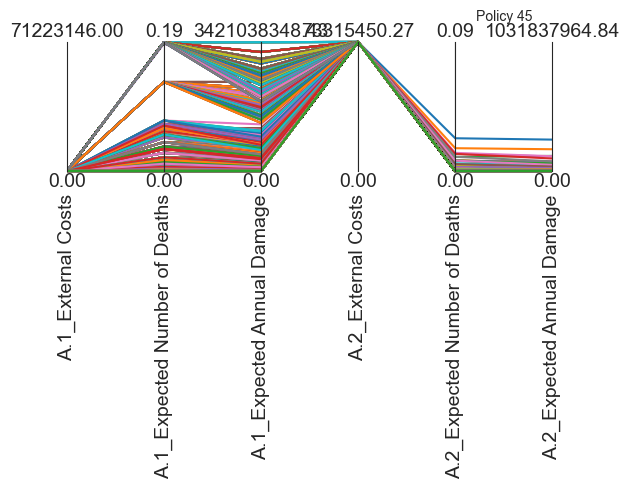

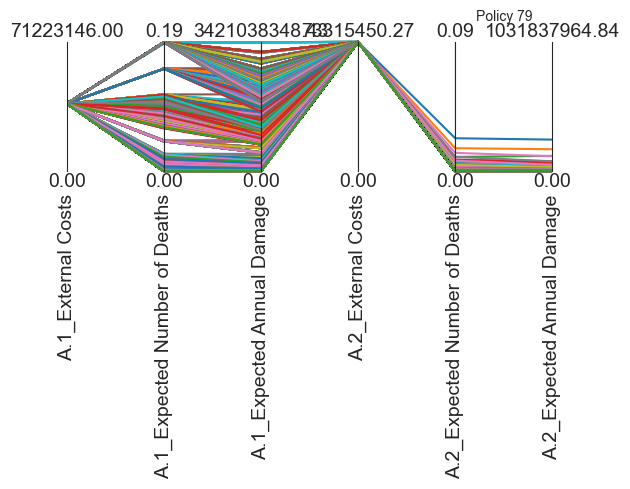

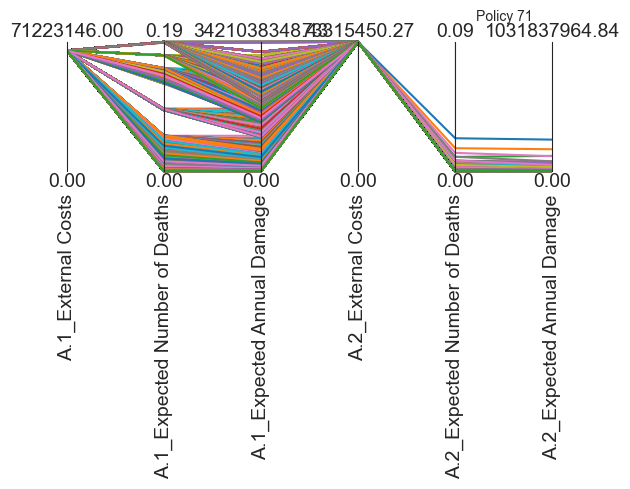

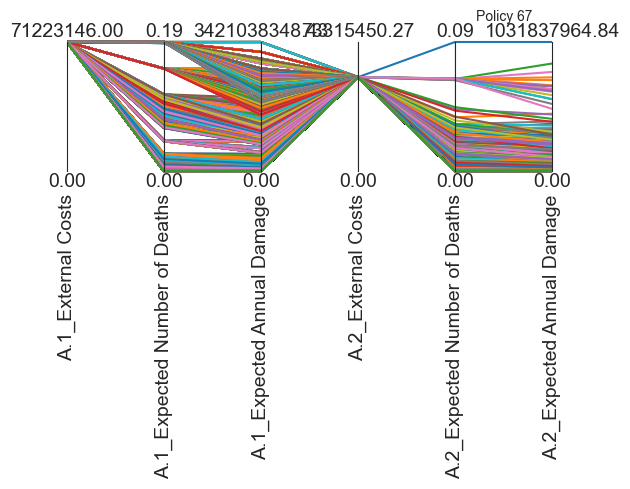

In [17]:
# Get unique indexes in the DataFrame
unique_indexes = df_final.index.unique().to_list()

# Get the limits for the parallel coordinate plots
limits = parcoords.get_limits(df_final)
limits.loc[0, [
    'A.1_External Costs', 'A.1_Expected Number of Deaths',
    'A.1_Expected Annual Damage', 'A.2_External Costs',
    'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage'
]] = 0

# Create a parallel coordinate plot for each unique index
for index in unique_indexes:
    rows = df_final.loc[df_final.index == index]

    # Create the parallel coordinate axes
    paraxes = parcoords.ParallelAxes(limits)

    # Plot the rows with the assigned color
    paraxes.plot(rows, label=str(index))

    # Display the legend
    plt.title(label= f'Policy {index}',
          fontsize=10,)
    
    # Display the plot
    plt.show()

The policies 45, 79, and 71 appear to be similarly vulnerable to certain outcomes. However, policy 67, seems to be most vulnerable for all the otucomes, except for external costs. To gain a deeper understanding of the vulnerability of these policies, we will conduct a PRIM (Patient Rule Induction Method) analysis on them. As also done in the previous PRIM analysis, we will work with the normalized composite score for the outcomes of interest (being Damage and Deaths for both locations). 

In [18]:
# Set up the scaler to normalise the results
scaler = MinMaxScaler()
normalized_ooi = scaler.fit_transform(df_outcomes[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
composite_ooi = normalized_ooi.sum(axis=1)

# Add the composite ooi to the dataframe
df_outcomes['composite_ooi'] = composite_ooi 

In [26]:
df_outcomes.head()

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi
0,0,0.000000,0.000000e+00,7.331545e+07,0.001637,1.926591e+07,0.037220
1,0,0.002254,3.974627e+07,7.331545e+07,0.000000,0.000000e+00,0.023228
2,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,0.000000
3,0,0.002254,3.974627e+07,7.331545e+07,0.001027,1.222889e+07,0.046719
4,0,0.000000,0.000000e+00,7.331545e+07,0.000000,0.000000e+00,0.000000


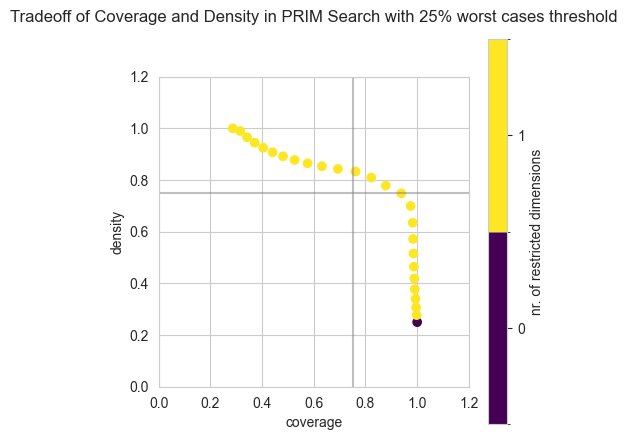

In [49]:
# To find the worst case scenarios, we will consider the worst 25% of the scenarios based on the composite ooi
percentile_composite_ooi = np.percentile(df_outcomes["composite_ooi"], 75)

# Bool the values if they are larger than the threshold
threshold_df = pd.DataFrame()
threshold_df = df_outcomes["composite_ooi"] > percentile_composite_ooi

# Pick threshold of 0.9, since that is the threshold we used in the PRIM search in the other notebook, same for peel_alpha
prim_alg = prim.Prim(experiments_sliced, threshold_df, threshold=0.9, peel_alpha=0.1)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
# We draw lines at 0.75 to more easily see if we can find a box which exceeds a coverage and density of 0.75
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 25% worst cases threshold', y=1.15)

plt.savefig("images/PRIM_tradeoff_scenarios")
plt.show()

The PRIM appears to have found multiple boxes meeting our constrain of 75%. We will have a closer look:

In [50]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.250000,0,1.000000,0.250000,0
1,0.998002,0.277239,1,0.899946,0.277239,1
2,0.995773,0.307382,2,0.809882,0.307382,1
3,0.993775,0.340854,3,0.728886,0.340854,1
4,0.990932,0.377665,4,0.655959,0.377665,1
5,0.989165,0.418901,5,0.590333,0.418901,1
6,0.987244,0.464596,6,0.531238,0.464596,1
7,0.985707,0.515472,7,0.478060,0.515472,1
8,0.984323,0.572035,8,0.430185,0.572035,1
9,0.982786,0.634627,9,0.387151,0.634627,1


We will futher inspect box 13, since that one scores the most decently for both coverage and density. Both higher than 0.80.

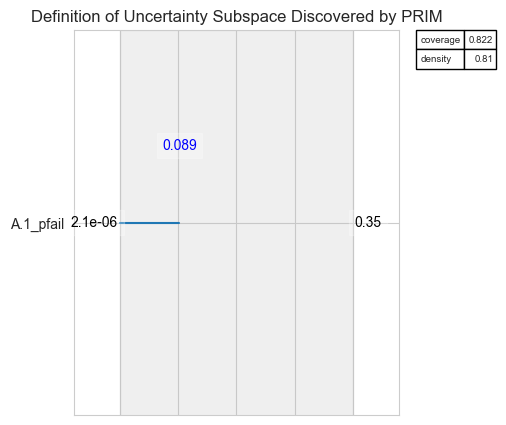

In [51]:
# Further inspecting box X to see which dimensions are being restricted
box1.select(13)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
plt.savefig('images/scenario_discovery__prim_boundary.png')
plt.show()

As expected, the uncertainty A.1_pfail is most important considering the worst-case scenario's. Furthermore, the value is very small, which means a high a change of A.1pfail actually happening. 

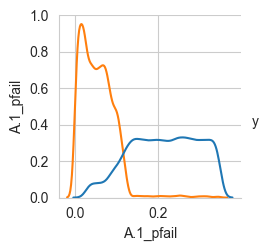

In [52]:
box1.show_pairs_scatter()
plt.savefig('images/prim_pairplot.png')
plt.show()

In [53]:
# Set the limits based on the PRIM box
limits = box1.box_lims[11]
limits

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
0,"{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",0,30.062009,0.000002,"{1.5, 10.0, 1.0}",30.000705,0.000079,"{1.5, 10.0, 1.0}",30.015740,0.000265,"{1.0, 10.0, 1.5}",30.005383,0.000021,"{1.0, 10.0, 1.5}",30.006804,0.000042,"{1.5, 10.0, 1.0}"
1,"{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}",132,349.992790,0.109039,"{1.5, 10.0, 1.0}",349.999139,0.999938,"{1.5, 10.0, 1.0}",349.975759,0.999946,"{1.0, 10.0, 1.5}",349.995618,0.999946,"{1.0, 10.0, 1.5}",349.971418,0.999998,"{1.5, 10.0, 1.0}"


In [54]:
# Setup a dataframe which we can later use to filter the experiments based on the PRIM box limits
combined_df_new = experiments.copy()
combined_df_new = combined_df_new.reset_index(drop=True)
combined_df_new = combined_df_new.merge(df_outcomes[['composite_ooi']], how = 'left', left_index = True, right_index = True)
combined_df_new['In box limits'] = True

In [55]:
# Create a mask initialized to True
mask = np.ones(len(combined_df_new), dtype=bool)

# Iterate over the constraints and update the mask
for unc in limits:
    if isinstance(limits.loc[0, unc], set):
        mask &= combined_df_new[unc].isin(limits.loc[0, unc])
    else:
        mask &= (combined_df_new[unc] >= limits.loc[0, unc]) & (combined_df_new[unc] <= limits.loc[1, unc])

# Update the 'In box limits' column based on the mask
combined_df_new['In box limits'] = mask

In [57]:
# Use new column to filter the rows, then drop this column
combined_df_new = combined_df_new[combined_df_new['In box limits']]
combined_df_new = combined_df_new.drop(['In box limits'], axis=1)
print(f'{combined_df_new.shape[0]} fall within the PRIM box limits')

16320 fall within the PRIM box limits


It appears that there are more cases in the PRIM box than identified in the other notebook (13013). This increase is partly because the dataset we started with contains more rows (52k instead of 50k). Additionally, both the coverage and density are now higher than in the previous analysis, with both metrics exceeding 0.80. By sorting the new dataframe in descending order based on the composite score, we can identify the least desired scenarios, as they have the worst scores regarding deaths and annual damage.

In [59]:
combined_df_new

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
1,1.5,1.5,1.5,112,45.942740,0.048710,10.0,140.411132,0.024664,1.0,...,7,7,6,4,4,7,37006,0,dikesnet,0.023228
3,1.5,1.5,1.5,8,71.302063,0.046825,1.0,345.456662,0.011393,1.0,...,7,7,6,4,4,7,23514,0,dikesnet,0.046719
5,1.5,1.5,1.5,44,86.004922,0.017269,1.5,345.948926,0.036662,1.0,...,7,7,6,4,4,7,15440,0,dikesnet,0.567732
10,1.5,1.5,1.5,37,149.824903,0.018815,1.5,189.307998,0.019760,1.5,...,7,7,6,4,4,7,32123,0,dikesnet,0.449793
13,3.5,1.5,1.5,35,31.447441,0.059785,1.0,99.623220,0.002858,1.0,...,7,7,6,4,4,7,11688,0,dikesnet,0.118286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52006,3.5,4.5,4.5,115,239.589678,0.011395,1.0,42.777662,0.783762,1.5,...,2,3,6,4,5,6,8083,3,dikesnet,1.538085
52010,3.5,4.5,4.5,92,318.193613,0.042841,1.0,137.353215,0.322609,1.5,...,2,3,6,4,5,6,7728,3,dikesnet,0.596073
52019,3.5,4.5,4.5,129,195.878214,0.101096,1.0,304.698959,0.915542,10.0,...,2,3,6,4,5,6,15114,3,dikesnet,0.153081
52031,3.5,4.5,4.5,94,204.677128,0.050882,1.5,235.909398,0.547089,10.0,...,2,3,6,4,5,6,47244,3,dikesnet,0.571789


In [68]:
combined_df_new_sorted = combined_df_new.sort_values(by='composite_ooi', ascending=False)    

In [88]:
combined_df_new_sorted.head()

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
39564,3.5,4.5,3.5,113,298.855387,0.017925,10.0,298.424133,0.000195,1.5,...,2,3,6,4,5,6,15749,3,dikesnet,2.280018
39090,1.5,3.5,1.5,93,98.499333,0.018113,10.0,111.536185,0.002817,1.5,...,2,3,6,4,5,6,35918,3,dikesnet,2.106249
39044,1.5,1.5,1.5,44,86.004922,0.017269,1.5,345.948926,0.036662,1.0,...,2,3,6,4,5,6,15440,3,dikesnet,2.010253
39049,1.5,1.5,1.5,37,149.824903,0.018815,1.5,189.307998,0.019760,1.5,...,2,3,6,4,5,6,32123,3,dikesnet,2.001629
27378,1.5,1.5,1.5,27,255.755486,0.007755,1.5,349.263375,0.102225,10.0,...,1,1,0,7,4,5,43701,2,dikesnet,1.999879


In [86]:
experiments[(experiments['scenario'] == 15749) & (experiments['policy'] == 3)][[
    '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
    '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
    '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
    'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
    'A.2_DikeIncrease 2', 'scenario', 'policy'
]]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,scenario,policy
39564,0,1,0,0,0,0,1,1,1,1,...,0,4,1,2,0,4,0,0,15749,3
